In [1]:
# Install only what's absolutely necessary on Kaggle
!pip install transformers datasets --quiet
!pip install seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 2.9 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incomp

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import shutil

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

import torch

print("Torch version:", torch.__version__)
print("Transformers version:", AutoTokenizer.__module__.split('.')[0])

2025-09-25 08:18:03.517309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758788283.703637      59 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758788283.757510      59 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Torch version: 2.6.0+cu124
Transformers version: transformers


In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
DATA_DIR = "/kaggle/input/contradictory-my-dear-watson/"
RESULT_DICT = {
    0: "entailment",
    1: "neutral",
    2: "contradiction"
}

In [5]:
# Load training data
df_train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
print("Training samples:", len(df_train))
df_train.head()

Training samples: 12120


,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [6]:
# Load test data
df_test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
print("Test samples:", len(df_test))
df_test.head()

Test samples: 5195


,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [7]:
def display_pair_of_sentence(x):
    print("Premise   :", x['premise'])
    print("Hypothesis:", x['hypothesis'])
    print("Language  :", x['language'])
    print("Label     :", RESULT_DICT.get(x['label'], x['label']))
    print()

print("Showing 10 examples from training set:\n")
df_train.head(10).apply(display_pair_of_sentence, axis=1)

# Show dataset shape
df_train.shape

Showing 10 examples from training set:

Premise   : and these comments were considered in formulating the interim rules.
Hypothesis: The rules developed in the interim were put together with these comments in mind.
Language  : English
Label     : entailment

Premise   : These are issues that we wrestle with in practice groups of law firms, she said. 
Hypothesis: Practice groups are not permitted to work on these issues.
Language  : English
Label     : contradiction

Premise   : Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
Hypothesis: J'essayais d'accomplir quelque chose.
Language  : French
Label     : entailment

Premise   : you know they can't really defend themselves like somebody grown uh say my age you know yeah
Hypothesis: They can't defend themselves because of their age.
Language  : English
Label     : entailment

Premise   : ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้า

(12120, 6)

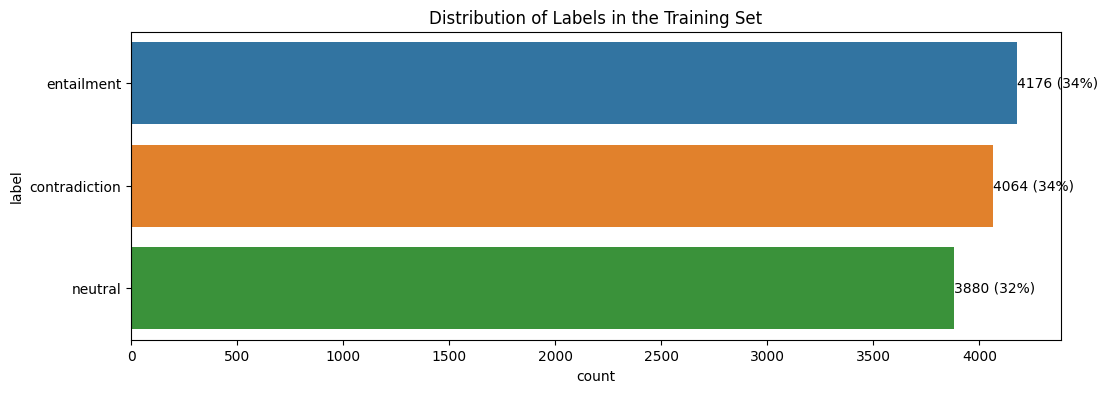

In [8]:
# Initialize the matplotlib figure
plt.figure(figsize=(12, 4))
sns.set_color_codes("pastel")
sns.despine()

# Plot label distribution
ax = sns.countplot(data=df_train, 
                   y="label",
                   order=df_train['label'].value_counts().index)

# Absolute & relative value labels
abs_values = df_train['label'].value_counts(ascending=False)
rel_values = df_train['label'].value_counts(ascending=False, normalize=True).values * 100
labels = [f'{count} ({percent:.0f}%)' for count, percent in zip(abs_values, rel_values)]

# Attach labels to bars
ax.bar_label(container=ax.containers[0], labels=labels)

# Replace label indices with readable class names
ax.set_yticklabels([RESULT_DICT[label] for label in abs_values.index])

# Title
ax.set_title("Distribution of Labels in the Training Set")
plt.show()


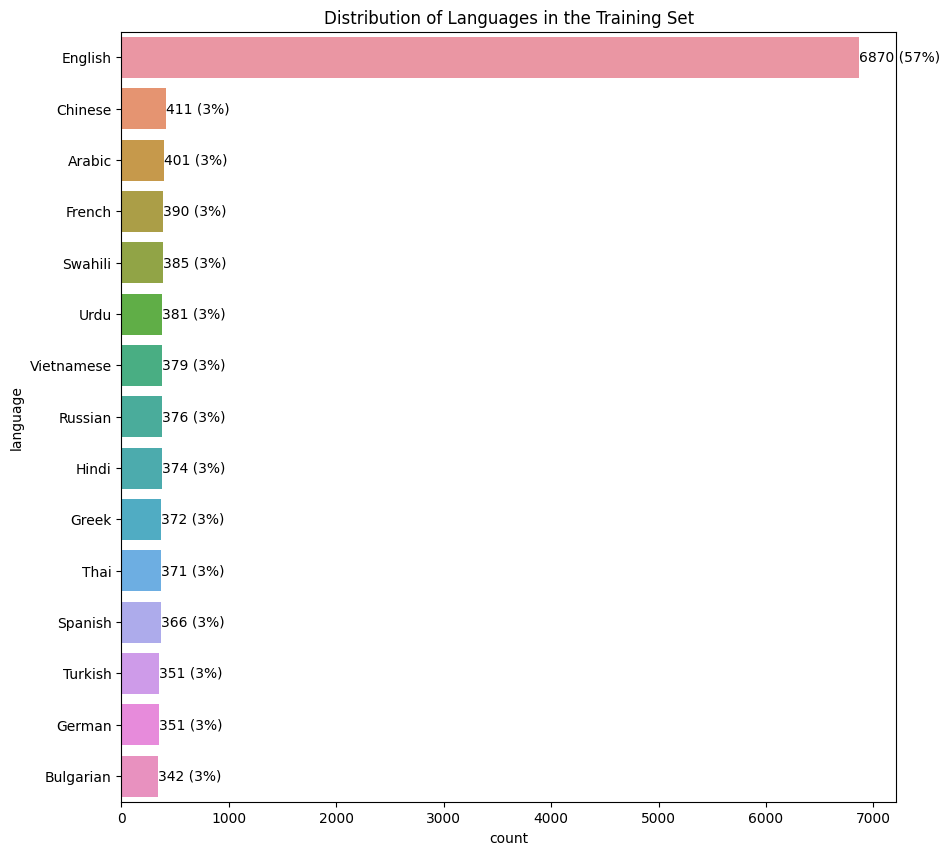

In [9]:
# Initialize the matplotlib figure
plt.figure(figsize=(10, 10))
sns.set_color_codes("pastel")
sns.despine()

# Plot language distribution
ax = sns.countplot(data=df_train,
                   y="language",
                   order=df_train['language'].value_counts().index)

# Absolute & relative values
abs_values = df_train['language'].value_counts(ascending=False)
rel_values = df_train['language'].value_counts(normalize=True).values * 100
labels = [f"{lang} ({pct:.0f}%)" for lang, pct in zip(abs_values, rel_values)]

# Attach labels to bars
ax.bar_label(container=ax.containers[0], labels=labels)

# Title
ax.set_title("Distribution of Languages in the Training Set")
plt.show()


In [10]:
# Add text length columns
df_train["premise_length"] = df_train["premise"].apply(len)
df_train["hypothesis_length"] = df_train["hypothesis"].apply(len)

# Show basic stats
df_train[["hypothesis_length", "premise_length"]].describe()

,hypothesis_length,premise_length
count,12120.000000,12120.000000
mean,53.892327,107.373185
std,25.302358,71.089954
min,4.000000,4.000000
25%,36.000000,55.000000
50%,51.000000,96.000000
75%,67.000000,146.000000
max,276.000000,967.000000


In [11]:
# Validation split ratio
VALIDATION_SPLIT = 0.3
TRAIN_SIZE = int(df_train.shape[0] * (1 - VALIDATION_SPLIT))

# Batch size
BATCH_SIZE = 32 if torch.cuda.is_available() else 16

print(f"Train size: {TRAIN_SIZE}, Batch size: {BATCH_SIZE}")

Train size: 8484, Batch size: 32


In [12]:
# Initialize tokenizer
model_name = "xlm-roberta-base" 
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [13]:
# Split into train and validation sets
train_df, val_df = train_test_split(df_train, test_size=VALIDATION_SPLIT, stratify=df_train['label'], random_state=42)

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["premise"], example["hypothesis"], padding="max_length", truncation=True, max_length=256)

# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Rename 'label' column to 'labels' for Trainer compatibility
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")

# Set format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print("Tokenization complete. Example:")
train_dataset[0]

Map:   0%|          | 0/8484 [00:00<?, ? examples/s]

Map:   0%|          | 0/3636 [00:00<?, ? examples/s]

Tokenization complete. Example:


{'labels': tensor(2),
 'input_ids': tensor([     0,   1087,    652,  80738,    245,     29,    518, 101253,    989,
             49,  25510,  20803,   4476,   3433,  13390,  60303,      4,   4560,
          58382,     77,  81250,  29776,   2574, 176807,    637, 138446,   1739,
         237412,   4798, 202915,      5,      2,      2,   4560,  58382, 206582,
            197,      4,   7193,   1266,      4,     35,  79971,  14424,   1739,
            969, 108410,    105,      2,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,  

In [14]:
from transformers import AutoModelForSequenceClassification

# Load pretrained model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
).to(device)

# Print model architecture summary
print(model)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [15]:
from transformers import TrainingArguments, Trainer

# Training configuration
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="none", 
    fp16=torch.cuda.is_available(), 
)

# Accuracy metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

/tmp/ipykernel_59/1687667463.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.925900,0.926699,0.589659
2,0.823000,0.762884,0.683718
3,0.653200,0.741589,0.701870


TrainOutput(global_step=798, training_loss=0.8666597016174393, metrics={'train_runtime': 695.9428, 'train_samples_per_second': 36.572, 'train_steps_per_second': 1.147, 'total_flos': 3348381354006528.0, 'train_loss': 0.8666597016174393, 'epoch': 3.0})

In [16]:
# Tokenize test set
test_dataset = Dataset.from_pandas(df_test)
test_dataset = test_dataset.map(
    lambda x: tokenizer(x["premise"], x["hypothesis"], truncation=True, padding="max_length", max_length=256),
    batched=True
)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Predict using Hugging Face trainer
predictions = trainer.predict(test_dataset).predictions
predicted_labels = np.argmax(predictions, axis=1)

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

In [17]:
# Create submission DataFrame
submission = pd.DataFrame({
    "id": df_test["id"],
    "prediction": predicted_labels
})

# Preview the submission
submission.head()


,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,2


In [18]:
# Save submission file
submission.to_csv("submission.csv", index=False)
print(" submission.csv saved and ready!")

 submission.csv saved and ready!
